In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

pm.__version__

'3.6'

In [16]:
X = np.arange(1989,2018,1).reshape(-1,1)
X.shape[0]

29

In [17]:
y = np.array([0,0,0,0,20,50,350,300,320,140,120,200,100,50,10,3,2,0,0,0,2,0,0,0,0,0,0,0,0])

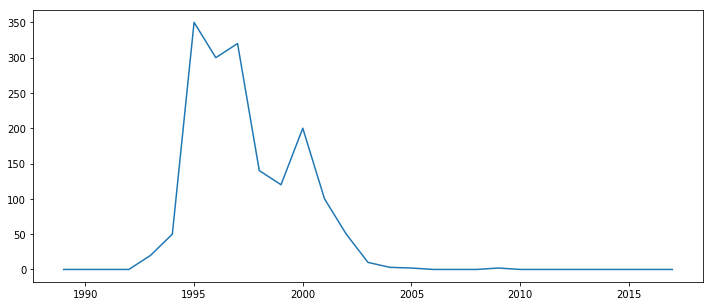

In [29]:
fig = plt.figure(figsize=(12,5))

plt.plot(X,y)
plt.show()

# PYMC3

In [19]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -179.58, ||grad|| = 2.2755: 100%|██████████| 19/19 [00:00<00:00, 117.82it/s]  


In [20]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])]})

,Parameter,Value at MAP
0,ℓ,2.148673
1,η,93.185123
2,σ,33.197896


Plotting f:
$$f(x)$$

In [21]:
# new values from x=0 to x=20
X_new = np.linspace(1989, 2020, 100)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=500)


100%|██████████| 500/500 [00:57<00:00,  8.70it/s]


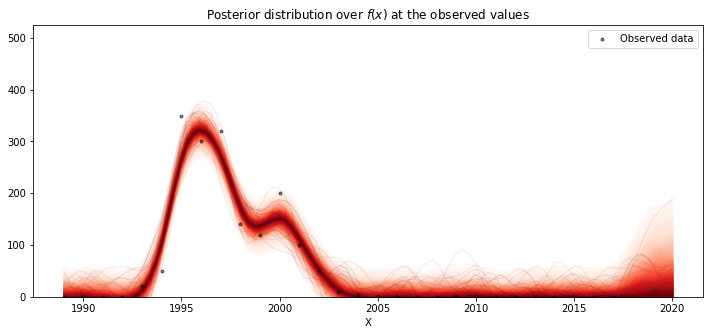

In [22]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
#plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13])
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)

plt.show()

Now y:

$$y = f(x) + \sigma$$

In [23]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=500)

100%|██████████| 500/500 [00:39<00:00, 12.63it/s]


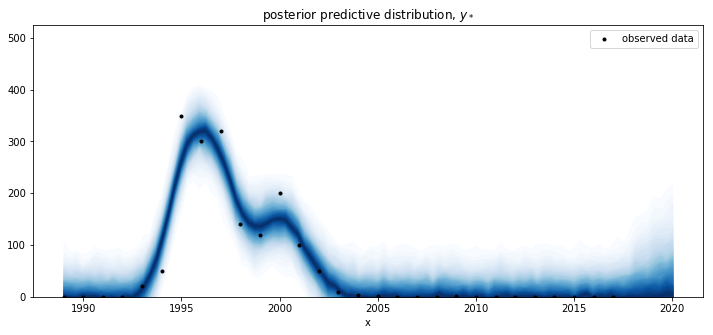

In [28]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="Blues")

# overlay a scatter of one draw of random points from the
#  posterior predictive distribution
#plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data")

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, $y_*$")
plt.legend()

plt.ylim(0,y.max()*1.5)


plt.show()

# Variying intercepts for two timelines:

In [52]:
X = np.arange(1989,2018,1).reshape(-1,1)
y1 = [0,0,0,0,20,50,350,300,320,140,120,200,100,50,10,3,2,0,0,0,2,0,0,0,0,0,0,0,0]
y2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,0,35,30,80,100,90,105]

y = np.array(y1 + y2)
index = np.array([0]*len(y1)+[1]*len(y2))

In [53]:
index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

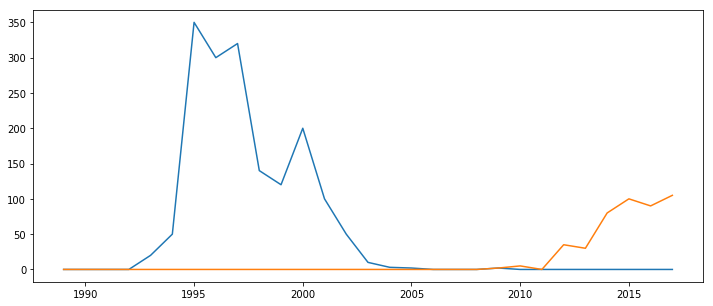

In [57]:
fig = plt.figure(figsize=(12,5))

plt.plot(X,y[index==0], X, y[index==1])
plt.show()

In [61]:
# the model

with pm.Model() as model_a:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)

    cov0 = η[0]**2 * pm.gp.cov.Matern52(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.Matern52(1, ℓ[1])

    gp0 = pm.gp.Marginal(cov_func=cov0)
    gp1 = pm.gp.Marginal(cov_func=cov1)


    σ = pm.HalfCauchy("σ", beta=5, shape = 2)
    
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp_a = pm.find_MAP()

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -306.08, ||grad|| = 1.3115: 100%|██████████| 18/18 [00:00<00:00, 54.47it/s]  


In [73]:
# pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
#               "Value at MAP": [float(mp_a["ℓ"]), float(mp_a["η"]), float(mp_a["σ"])]})

mp_a

{'η': array([93.18444982, 32.11922112]),
 'η_log__': array([4.53458086, 3.46945464]),
 'σ': array([33.1979856 ,  6.33841302]),
 'σ_log__': array([3.5024892 , 1.84662843]),
 'ℓ': array([2.14866796, 4.90744965]),
 'ℓ_log__': array([0.7648481 , 1.59075439])}

In [74]:
# add the GP conditional to the model, given the new X values
with model_a:
    f_pred_a0 = gp0.conditional("f_pred0", X_new)
    f_pred_a1 = gp1.conditional("f_pred1", X_new)


# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model_a:
    pred_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a0], samples=500)
    pred_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a1], samples=500)



100%|██████████| 500/500 [00:57<00:00,  8.67it/s]


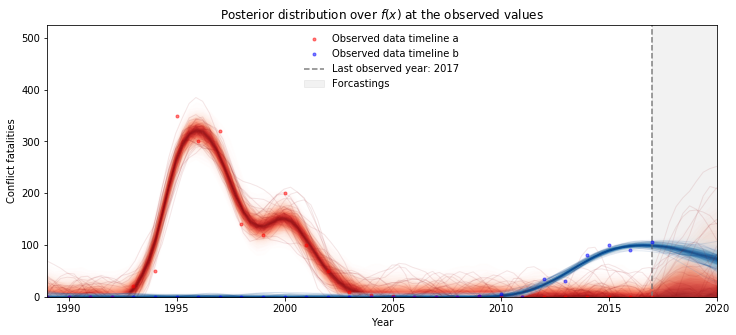

In [110]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_a0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_a1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()